<a href="https://colab.research.google.com/github/ArunPrasath1205/Retail-Sales-Prediction-ML-Project/blob/main/Part_2_Rossmann_sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings 
warnings.filterwarnings("ignore")

In [3]:
from sklearn.ensemble import RandomForestRegressor

In [4]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [91]:
df = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_cleaned.csv", parse_dates=['Date'])
comparison_df = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/dt_results.csv")
#df_train = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_train.csv")
#df_test = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_test.csv")

In [94]:
#setting date and store as index
df.set_index(['Date','Store'],inplace=True)
#sorting index following the time series
df.sort_index(inplace=True)

In [95]:
#slicing the most recent six weeks and creating train and test set
#train
start_train = pd.to_datetime("2013-01-01")
end_train = pd.to_datetime("2015-06-14")
df_train = df.loc[start_train:end_train]
#test
start_test = pd.to_datetime("2015-06-15")
end_test = pd.to_datetime("2015-07-31")
df_test = df.loc[start_test:end_test]

In [96]:
X_train = df_train.drop('Sales',axis=1)
y_train = df_train[['Sales']]
X_test = df_test.drop('Sales',axis=1)
y_test = df_test[['Sales']]
print(f'The shape of X_train is: {X_train.shape}')
print(f'The shape of y_train is: {y_train.shape}')
print(f'The shape of X_test is: {X_test.shape}')
print(f'The shape of y_test is: {y_test.shape}')

The shape of X_train is: (798486, 17)
The shape of y_train is: (798486, 1)
The shape of X_test is: (45852, 17)
The shape of y_test is: (45852, 1)


In [97]:
from sklearn.preprocessing import OneHotEncoder
#categorical features
categorical_cols = ['DayOfWeek', 'StoreType', 'Assortment']
#fit encoder
encoder = OneHotEncoder(sparse=False)
# train
encoder.fit(X_train[categorical_cols])
encoded_features = list(encoder.get_feature_names(categorical_cols))
X_train[encoded_features] = encoder.transform(X_train[categorical_cols])
# test
X_test[encoded_features] = encoder.transform(X_test[categorical_cols])
# drop original features
X_train.drop(categorical_cols,axis=1,inplace=True)
X_test.drop(categorical_cols,axis=1,inplace=True)

In [98]:
# scaling
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train[list(X_train.columns)] = stdsc.fit_transform(X_train[list(X_train.columns)])
X_test[list(X_test.columns)] = stdsc.transform(X_test[list(X_test.columns)])

scaler = StandardScaler()
y_train[list(y_train.columns)] = scaler.fit_transform(y_train[list(y_train.columns)])
y_test[list(y_test.columns)] = scaler.transform(y_test[list(y_train.columns)])

In [99]:
random_forest = RandomForestRegressor(n_estimators=100,random_state=42)
random_forest.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [100]:
#function to evaluate the model
def model_evaluation(model_name,model_variable,X_train,y_train,X_test,y_test):
  ''' This function predicts and evaluates various models for regression algorithms, visualizes results 
      and creates a dataframe that compares the various models.'''
      
  #making predictions
  y_pred_train = model_variable.predict(X_train)
  y_pred_test = model_variable.predict(X_test)

  # Plot the test results
  a = y_test.copy()
  a['Pred Sales'] = y_pred_test.tolist()
  df_plot = a.reset_index(level=['Date'])
  plot = df_plot.groupby('Date')['Sales','Pred Sales'].sum()
  sns.lineplot(data = plot)
  plt.ylabel("Total Sales and Predicted Sales")
  plt.xticks(rotation = 25)

  #calculate metrics and print the results for test set
  #Mean Absolute Error or MAE
  MAE_train = round(mean_absolute_error(y_train,y_pred_train),6)
  MAE_test = round(mean_absolute_error(y_test,y_pred_test),6)
  #Mean Squared Error or MSE
  MSE_train = round(mean_squared_error(y_train,y_pred_train),6)
  MSE_test = round(mean_squared_error(y_test,y_pred_test),6)
  #Root Mean Squared Error or RMSE
  RMSE_train = round(mean_squared_error(y_train,y_pred_train,squared=False),6)
  RMSE_test = round(mean_squared_error(y_test,y_pred_test,squared=False),6)
  #R2
  R2_train = round(r2_score(y_train, y_pred_train),6)
  R2_test = round(r2_score(y_test, y_pred_test),6)
  #Adjusted R2
  Adj_r2_train = round(1 - (1-r2_score(y_train, y_pred_train)) * (len(y_train)-1)/(len(y_train)-X_train.shape[1]-1),6)
  Adj_r2_test = round(1 - (1-r2_score(y_test, y_pred_test)) * (len(y_test)-1)/(len(y_test)-X_test.shape[1]-1),6)
  #printing test results
  print(f'The Mean Absolute Error for the validation set is {MAE_test}')
  print(f'The Mean Squared Error for the validation set is {MSE_test}')
  print(f'The Root Mean Squared Error for the validation set is {RMSE_test}')
  print(f'The R^2 for the validation set is {R2_test}')
  print(f'The Adjusted R^2 for the validation set is {Adj_r2_test}')

  #Saving our results
  global comparison_columns
  metric_scores = [model_name,MAE_train,MSE_train,RMSE_train,R2_train,Adj_r2_train,MAE_test,MSE_test,RMSE_test,R2_test,Adj_r2_test]
  final_dict = dict(zip(comparison_columns,metric_scores))
  return [final_dict]

In [105]:
#function to create the comparison table
final_list = []
def add_list_to_final_df(dict_list):
  global final_list
  for elem in dict_list:
    final_list.append(elem)
  global comparison_df
  comparison_df = pd.DataFrame(final_list, columns= comparison_columns)

In [102]:
#Columns needed to compare metrics
comparison_columns = ['Model_Name', 'Train_MAE', 'Train_MSE', 'Train_RMSE', 'Train_R2', 'Train_Adj_R2' ,'Test_MAE', 'Test_MSE', 'Test_RMSE', 'Test_R2', 'Test_Adj_R2']


The Mean Absolute Error for the validation set is 0.14187
The Mean Squared Error for the validation set is 0.035382
The Root Mean Squared Error for the validation set is 0.1881
The R^2 for the validation set is 0.962439
The Adjusted R^2 for the validation set is 0.962416


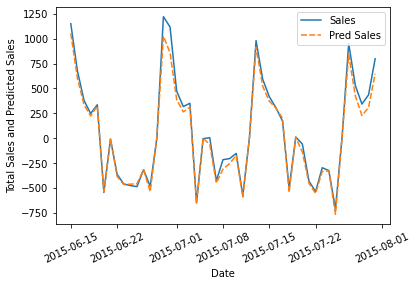

In [103]:
#model evaluation 
random_f = model_evaluation('Random Forest Regressor',random_forest,X_train,y_train,X_test,y_test)

In [106]:
# updating comparison df
add_list_to_final_df(random_f)

In [110]:
comparison_df1 = pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/dt_results.csv")
comparison_df1

,Unnamed: 0,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,0,Decision Tree Regressor,0.000001,0.0,0.000683,1.0,1.0,0.198112,0.074079,0.272174,0.921358,0.92131


In [111]:
comparison_df2 = comparison_df
comparison_df2

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Random Forest Regressor,0.043688,0.003573,0.059772,0.996427,0.996427,0.14187,0.035382,0.1881,0.962439,0.962416


In [136]:
result = comparison_df1.append(comparison_df2)
result.drop(columns = "Unnamed: 0", axis = 1, inplace = True)
#result.set_index("Model_Name", inplace = True)
display(result)

,Model_Name,Train_MAE,Train_MSE,Train_RMSE,Train_R2,Train_Adj_R2,Test_MAE,Test_MSE,Test_RMSE,Test_R2,Test_Adj_R2
0,Decision Tree Regressor,0.000001,0.000000,0.000683,1.000000,1.000000,0.198112,0.074079,0.272174,0.921358,0.921310
0,Random Forest Regressor,0.043688,0.003573,0.059772,0.996427,0.996427,0.141870,0.035382,0.188100,0.962439,0.962416


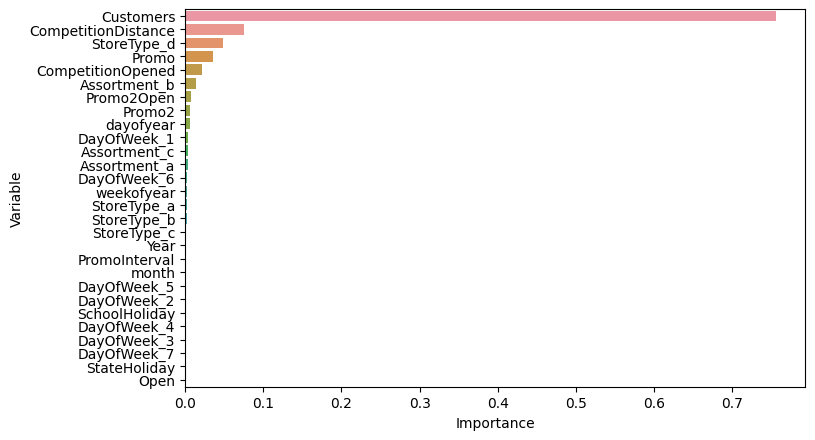

In [134]:
#visualising feature importance of XGB
feature_imp = pd.DataFrame({"Variable": X_test.columns,"Importance": random_forest.feature_importances_})
feature_imp.sort_values(by="Importance", ascending=False, inplace = True)
sns.barplot(x=feature_imp['Importance'], y= feature_imp['Variable'])
plt.rcParams.update({'figure.figsize':(12,10),'figure.dpi':100})

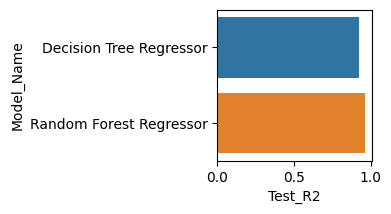

In [142]:
#visualising our comparison df for Test R2
sns.barplot(y=result['Model_Name'], x = result['Test_R2'])
plt.rcParams.update({'figure.figsize':(5,2),'figure.dpi':100})

## Decision Tree Vs Random Forest


In [143]:
decision_tree_r2 = 0.921358
random_forest_r2 = 0.962439	

In [145]:
# Improvement %

improvement_r = ((random_forest_r2 - decision_tree_r2)/decision_tree_r2)*100
print('Model Performance')
print(f'Improvement of {round(improvement_r,3)} % was seen in Random Forest against Decision Tree.')

Model Performance
Improvement of 4.459 % was seen in Random Forest against Decision Tree.


##Store wise sales Predictions

In [147]:
#predictions 
y_pred_test = random_forest.predict(X_test)
six_weeks_sales_df = y_test.copy()
six_weeks_sales_df['Pred_Sales'] = y_pred_test.tolist()

In [148]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                      
2015-06-15 1     -0.328664   -0.472185
           2      0.574378    0.483420
           3      1.252047    1.197001
           4      1.572145    1.468615
           5      0.486429    0.465416

In [149]:
six_weeks_sales_df.describe()

,Sales,Pred_Sales
count,45852.000000,45852.000000
mean,0.078755,0.030492
std,0.970563,0.936059
min,-5.663221,-5.215975
25%,-0.535373,-0.555635
50%,0.078925,0.028593
75%,0.706517,0.641693
max,4.411868,3.712608


In [152]:
#importing minmax scaler
from sklearn.preprocessing import MinMaxScaler
#fitting to the original data
cleaned_unscaled_data= pd.read_csv("/content/drive/MyDrive/Data Science/Module 04 ML/Retail sales prediction ML project/df_cleaned.csv")
#fitting numerical columns
numerical_cols = ['Sales']
scaler = MinMaxScaler()
scaler.fit(cleaned_unscaled_data[numerical_cols])

MinMaxScaler()

In [153]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                       
2015-06-15 1       1.591742    0.614933
           2       7.737877    7.118813
           3      12.350117   11.975470
           4      14.528713   13.824084
           5       7.139296    6.996281

In [154]:
#inverse
six_weeks_sales_df[['Sales']] = scaler.inverse_transform(six_weeks_sales_df[['Sales']])
six_weeks_sales_df[['Pred_Sales']] = scaler.inverse_transform(six_weeks_sales_df[['Pred_Sales']])

In [155]:
six_weeks_sales_df.head()

Sales  Pred_Sales
Date       Store                        
2015-06-15 1       14.662092    8.013895
           2       56.492907   52.279533
           3       87.883976   85.334118
           4      102.711580   97.915848
           5       52.418944   51.445578

In [156]:
six_weeks_sales_df.loc[('2015-06-15',5)]

Sales         52.418944
Pred_Sales    51.445578
Name: (2015-06-15 00:00:00, 5), dtype: float64

In [159]:
six_weeks_sales_df.loc[('2015-07-28',56)]

Sales         60.367989
Pred_Sales    48.841874
Name: (2015-07-28 00:00:00, 56), dtype: float64